In [58]:
# import necessary packages
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import FreqDist

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities, matutils

sns.set_style('ticks')

## Natural Language Processing Models
Now that the document-term matrices have been created, I will explore the data to ensure that the corpus is in a suitable format to run sentiment analysis.

In [59]:
# read in the cleaned data
timelines = pd.read_pickle('timelines_cleaned_lemma.pkl')
favorites = pd.read_pickle('favorites_cleaned_lemma.pkl')

In [60]:
# add a column to each dataframe to be able to identify where the tweet came from
timelines['type'] = 'timeline'
favorites['type'] = 'favorite'

In [61]:
# concatentate the dataframes of the timelines and favorites
full_df = pd.concat([timelines, favorites.drop(columns='favorited_by_id')])
print(full_df.shape)
full_df.head()

(1163063, 11)


,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text,type
0,1236035178331541505,Fri Mar 06 21:05:25 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,understanding power analysis in ab testing,timeline
1,1234619024736182272,Mon Mar 02 23:18:08 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,international talent segmentation for startups,timeline
2,1234276283745546240,Mon Mar 02 00:36:12 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,3,0,no thoughts head empty,timeline
3,1232902175753289728,Thu Feb 27 05:35:59 +0000 2020,baka_brooks,2649540547,1.232805e+18,lolegra,1.333492e+09,1,0,hi me,timeline
4,1232802180899332096,Wed Feb 26 22:58:38 +0000 2020,baka_brooks,2649540547,1.232699e+18,almeezyuh,1.006084e+08,0,0,bakabrooks,timeline


In [62]:
# instantiate word cloud
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

In [63]:
# Combine all of the tweets into a single string
all_tweets = [tweet for tweet in full_df.text]
all_tweets = ' '.join(all_tweets)

In [64]:
sample_tweets = full_df['text'].sample(500000)
sample_string = [tweet for tweet in sample_tweets]
sample_string = ' '.join(sample_string)

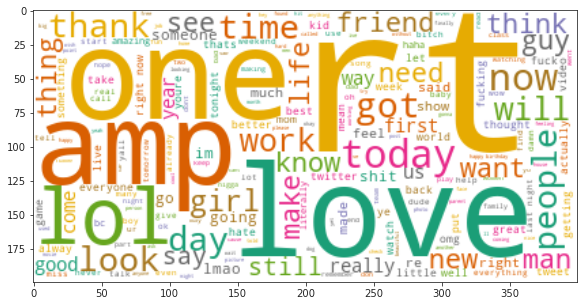

In [65]:
# generate word cloud from all tweets
cloud_tweets = wc.generate(sample_string)

plt.figure(figsize=(10,5))
plt.imshow(cloud_tweets, interpolation='bilinear');

Dope! No words really stick out as outliers here. It looks like the major words are all relevant to the Samsung event and/or features of the phone which is exactly what I want.

## Sentiment Analysis
My main objective is to accurately assign sentiment scores to the tweets and determine which features/aspects of the phone corresponded to each emotion. 

In [66]:
sentiment_df = full_df.copy()

In [67]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

sentiment_df['textblob_polarity'] = sentiment_df['text'].apply(pol)
sentiment_df['textblob_subjectivity'] = sentiment_df['text'].apply(sub)
sentiment_df.head()

,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text,type,textblob_polarity,textblob_subjectivity
0,1236035178331541505,Fri Mar 06 21:05:25 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,understanding power analysis in ab testing,timeline,0.0,0.0
1,1234619024736182272,Mon Mar 02 23:18:08 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,international talent segmentation for startups,timeline,0.0,0.0
2,1234276283745546240,Mon Mar 02 00:36:12 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,3,0,no thoughts head empty,timeline,-0.1,0.5
3,1232902175753289728,Thu Feb 27 05:35:59 +0000 2020,baka_brooks,2649540547,1.232805e+18,lolegra,1.333492e+09,1,0,hi me,timeline,0.0,0.0
4,1232802180899332096,Wed Feb 26 22:58:38 +0000 2020,baka_brooks,2649540547,1.232699e+18,almeezyuh,1.006084e+08,0,0,bakabrooks,timeline,0.0,0.0


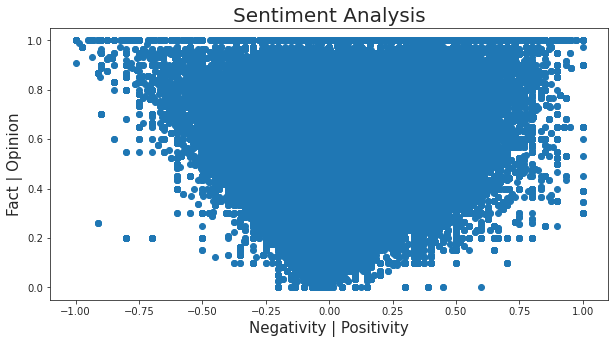

In [68]:
plt.figure(figsize=(10,5))

x = sentiment_df.textblob_polarity
y = sentiment_df.textblob_subjectivity
plt.scatter(x, y)
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('Negativity | Positivity', fontsize=15)
plt.ylabel('Fact | Opinion', fontsize=15);

### VADER Sentiment Analysis (Compound Scores)

In [69]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [70]:
analyzer = SentimentIntensityAnalyzer()
scores = []
for doc in sentiment_df['text']:
    vs = analyzer.polarity_scores(doc)
    scores.append(vs)

In [71]:
negative_scores = [score['neg'] for score in scores]
positive_scores = [score['pos'] for score in scores]
neutral_scores = [score['neu'] for score in scores]
compound_scores = [score['compound'] for score in scores]

In [72]:
sentiment_df['vader_neg'] = negative_scores
sentiment_df['vader_pos'] = positive_scores
sentiment_df['vader_neu'] = neutral_scores
sentiment_df['vader_compound'] = compound_scores
sentiment_df.head()

,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text,type,textblob_polarity,textblob_subjectivity,vader_neg,vader_pos,vader_neu,vader_compound
0,1236035178331541505,Fri Mar 06 21:05:25 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,understanding power analysis in ab testing,timeline,0.0,0.0,0.000,0.000,1.000,0.0000
1,1234619024736182272,Mon Mar 02 23:18:08 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,international talent segmentation for startups,timeline,0.0,0.0,0.000,0.412,0.588,0.4215
2,1234276283745546240,Mon Mar 02 00:36:12 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,3,0,no thoughts head empty,timeline,-0.1,0.5,0.667,0.000,0.333,-0.4588
3,1232902175753289728,Thu Feb 27 05:35:59 +0000 2020,baka_brooks,2649540547,1.232805e+18,lolegra,1.333492e+09,1,0,hi me,timeline,0.0,0.0,0.000,0.000,1.000,0.0000
4,1232802180899332096,Wed Feb 26 22:58:38 +0000 2020,baka_brooks,2649540547,1.232699e+18,almeezyuh,1.006084e+08,0,0,bakabrooks,timeline,0.0,0.0,0.000,0.000,1.000,0.0000


## Topic Modeling and Clustering

In [73]:
# create the corpus from the cleaned text using the user favorites
mask = sentiment_df['type'] == 'favorite'
corpus = list(sentiment_df.loc[mask].text)

In [74]:
# create a list of english language stopwords using nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [75]:
# create a CountVectorizer
cv = CountVectorizer(binary=True, stop_words=stop_words, min_df=10, max_df=0.9)
doc_word = cv.fit_transform(corpus)

## NMF
Non-negative matrix factorization will work better for tweets as it removes the "weights" factor (sigma) from single variable decomposiiton, deconstructing the documennt-term matrix to doc-topics and topics-terms.

In [76]:
# instantiate nmf model
nmf_model = NMF(7)
doc_topic_nmf = nmf_model.fit_transform(doc_word)

In [77]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [78]:
# display topics and words associated
display_topics(nmf_model, cv.get_feature_names(), 30)


Topic  0
like, feel, look, looks, would, really, shit, dont, someone, girl, feels, sounds, something, even, bitch, never, think, lol, say, said, man, make, need, see, always, looking, girls, damn, hate, men

Topic  1
im, going, gonna, dont, still, sorry, think, really, lol, ive, excited, right, sure, hi, getting, cant, data, say, fuck, proud, crying, ready, youre, next, done, fucking, back, happy, thats, trying

Topic  2
one, best, ever, day, thing, favorite, another, things, ive, year, two, last, person, life, seen, many, every, would, said, greatest, made, told, way, us, never, week, ago, make, buy, else

Topic  3
get, go, want, dont, back, need, let, gonna, trying, better, never, cant, shit, going, still, ready, home, work, someone, right, way, wanna, see, man, ass, enough, even, come, girl, could

Topic  4
time, new, got, day, today, amp, first, know, good, year, go, see, last, really, every, back, years, make, happy, want, life, work, best, think, us, ever, going, dont, never, sa

## LSA

In [79]:
n_topics = 7
lsa = TruncatedSVD(n_topics)
doc_topic_lsa = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_
topics = pd.DataFrame(lsa.components_.round(3),
             index = ["component_" + str(i) for i in range(0, n_topics)],
             columns = cv.get_feature_names())
display_topics(lsa, cv.get_feature_names(), 30)


Topic  0
like, one, im, get, people, time, know, love, day, really, got, new, amp, dont, good, today, go, see, want, first, would, feel, think, look, make, back, year, going, never, life

Topic  1
one, get, im, time, love, day, new, people, know, today, amp, got, first, good, year, go, see, back, best, want, going, life, happy, last, ever, think, dont, work, much, years

Topic  2
im, get, people, know, dont, go, going, love, gonna, want, good, see, back, still, think, really, sorry, need, cant, lol, right, excited, even, shit, let, work, fuck, ready, home, say

Topic  3
get, people, want, love, know, dont, go, amp, let, need, back, see, white, never, time, better, shit, black, someone, many, us, way, take, work, would, wanna, new, come, could, together

Topic  4
get, im, one, like, gonna, ready, going, trying, done, excited, tryna, tired, home, mad, away, paid, lets, bed, sorry, another, drunk, tickets, crying, rid, pregnant, hi, married, sleep, affordable, advertising

Topic  5
time,

## UMap Visualization

Run Kmeans clustering on document-term matrix and assign documents to clusters.

In [80]:
n_topics = 7
svd_model = TruncatedSVD(n_topics)
svd_model.fit(doc_word)

X_topics = svd_model.fit_transform(doc_word)

kmeans_labels = KMeans(n_clusters=n_topics, n_jobs = -1, random_state=22).fit_predict(X_topics)

Create the umap embedding using the SVD topic matrix.

In [81]:
import umap.umap_ as umap

# create the umap embedding
embedding = umap.UMAP(random_state=22).fit_transform(X_topics)

/home/jupyter/.local/lib/python3.7/site-packages/umap_learn-0.4.0rc1-py3.7.egg/umap/spectral.py:222: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/jupyter/.local/lib/python3.7/site-packages/umap_learn-0.4.0rc1-py3.7.egg/umap/spectral.py:222: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


Visualize embeddings and kmeans clusters in 2D vector space.

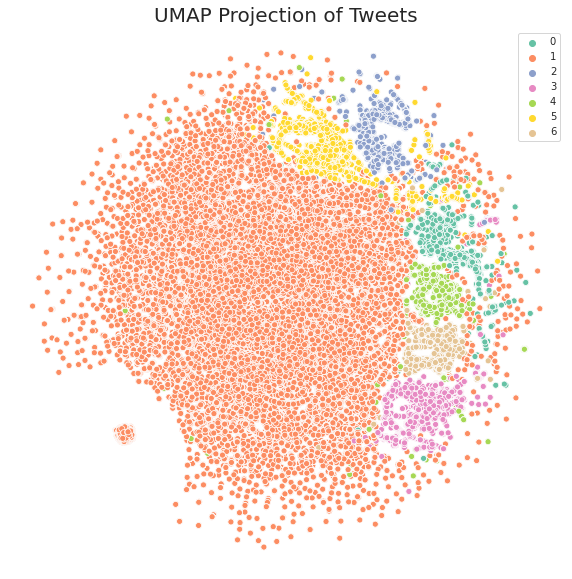

In [35]:
# plot the clusters (despined)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

plt.figure(figsize=(10,10))
sns.scatterplot(embedding[:, 0], embedding[:, 1], hue=kmeans_labels, palette='Set2')
plt.title('UMAP Projection of Tweets', fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('off')
plt.savefig('umap.png', transparent=True);

## t-SNE Visualization

In [66]:
from sklearn.manifold import TSNE

tsne_model = TSNE(random_state=22)
tsne_nmf = tsne_model.fit_transform(doc_topic_nmf)

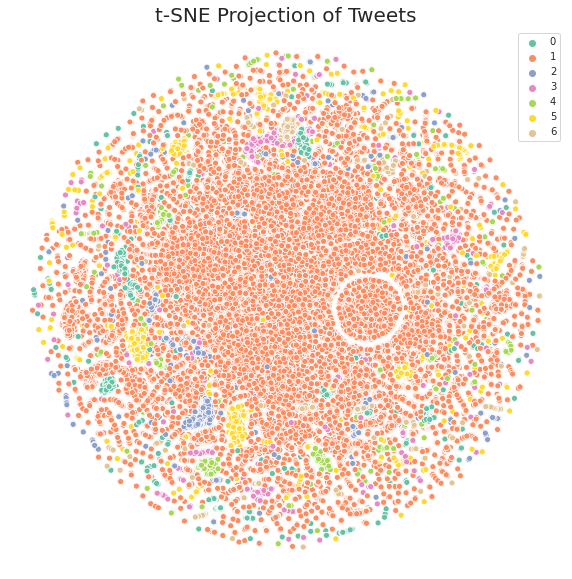

In [67]:
# plot the clusters (despined)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

plt.figure(figsize=(10,10))
sns.scatterplot(tsne_nmf[:, 0], tsne_nmf[:, 1], hue=kmeans_labels, palette='Set2')
plt.title('t-SNE Projection of Tweets', fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('off')
plt.savefig('tsne_lemma_7topics_despine.png', transparent=True);

It appears UMAP via KMeans was more successful in defining distinct clusters indicative of each topic. I will accept the UMAP visualization and cluster assignments via KMeans rather than t-SNE.

## Add clusters as features to dataframe

To create a recommendation system, I will combine the cluster labels from Kmeans/UMAP and the topic weights from the document-topic matrix created using NMF to the full dataframe with pre-processed text and polarity scores.

In [ ]:
# create a dataframe of the kmeans clusters
cluster_df = pd.DataFrame(kmeans_labels.reshape(-1,1), columns=['clusters'], dtype=np.int)
print(cluster_df.shape)
cluster_df.head()

In [ ]:
# create a dataframe from the document-topic matrix of NMF
doc_topic_df = pd.DataFrame(doc_topic_nmf, columns=['topic_' + str(col) for col in range(doc_topic_nmf.shape[1])])
print(doc_topic_df.shape)
doc_topic_df.head()

In [ ]:
# concatenate clusters and topics with full dataframe with sentiment scores
full_df = pd.concat([sentiment_df.loc[mask], cluster_df, doc_topic_df], axis=1)
print(full_df.shape)
full_df.head()

In [ ]:
# export combined dataframe
full_df.to_pickle('model_data.pkl')